In [55]:
from scipy.io import arff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer

# Load the data

The dataset is available both from the OpenML and the UCI archieve.
OpenML provides an arff file and UCI csv files

In [56]:
# Load the arff file from OpenML
data_arff = arff.loadarff('data/bank_marketing/phpkIxskf.arff')

# Load the csv fies from UCI
data_bank_full = pd.read_csv('data/bank_marketing/bank-additional-full.csv', sep=';')
#data_bank = pd.read_csv('../data/bank.csv', sep=';')

In [57]:
df_arff = pd.DataFrame(data_arff[0])
df_arff.head()
data_arff[1]

Dataset: bank-marketing-full
	V1's type is numeric
	V2's type is nominal, range is ('admin.', 'blue-collar', 'entrepreneur', 'housemaid', 'management', 'retired', 'self-employed', 'services', 'student', 'technician', 'unemployed', 'unknown')
	V3's type is nominal, range is ('divorced', 'married', 'single')
	V4's type is nominal, range is ('primary', 'secondary', 'tertiary', 'unknown')
	V5's type is nominal, range is ('no', 'yes')
	V6's type is numeric
	V7's type is nominal, range is ('no', 'yes')
	V8's type is nominal, range is ('no', 'yes')
	V9's type is nominal, range is ('cellular', 'telephone', 'unknown')
	V10's type is numeric
	V11's type is nominal, range is ('apr', 'aug', 'dec', 'feb', 'jan', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep')
	V12's type is numeric
	V13's type is numeric
	V14's type is numeric
	V15's type is numeric
	V16's type is nominal, range is ('failure', 'other', 'success', 'unknown')
	Class's type is nominal, range is ('1', '2')

In [58]:
data_bank_full.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Based on the better format and the more in depth description of the data, we decided to use the dataset from UCI, found on the following link: https://archive.ics.uci.edu/dataset/222/bank+marketing

# Analysis of the data

In [59]:
# First check if there are NaN values in the data frame
data_bank_full.isna().sum()

# based on the description of the data, for unknown values the string "unknown" is written 
data_bank_full.apply(pd.Series.value_counts).loc['unknown']

age                  NaN
job                330.0
marital             80.0
education         1731.0
default           8597.0
housing            990.0
loan               990.0
contact              NaN
month                NaN
day_of_week          NaN
duration             NaN
campaign             NaN
pdays                NaN
previous             NaN
poutcome             NaN
emp.var.rate         NaN
cons.price.idx       NaN
cons.conf.idx        NaN
euribor3m            NaN
nr.employed          NaN
y                    NaN
Name: unknown, dtype: float64

In [60]:
data_bank_full.dtypes
#data_bank_full.describe()

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object

In [61]:
# Number of samples and number of attributes
num_samples = data_bank_full.shape[0]
num_attributes = data_bank_full.shape[1] - 1 # last one is the class annotation
print("The number of samples is: ", str(num_samples))
print("The number of attributes is: ", str(num_attributes))

The number of samples is:  41188
The number of attributes is:  20


# Preprocessing Steps

## Response variable

In [62]:
# Renaming the column y to class
data_bank_full.rename(columns={"y": "class"}, inplace=True)
data_bank_full['class'].replace(['no', 'yes'],[0, 1], inplace=True)

Because we are preparing the data for classification the values need to be changed to numeric.

In [63]:
# Count the occurrences of each class value
class_counts = data_bank_full['class'].value_counts()

# Display the counts
print("Number of samples that belong to class 0: ", str(class_counts[0]))
print("Number of samples that belong to class 1: ", str(class_counts[1]))

Number of samples that belong to class 0:  36548
Number of samples that belong to class 1:  4640


This dataset is highly imbalanced with the majority class being class 0 (clients who have not subscribed to a term deposit) and minority class class 1 (clients who have subscribed to a term deposit). Imbalanced dataset are very common in classification tasks and this issue may affect our overall prediction accuracy

In [64]:
data_bank_full.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,class
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


## Features

### Changing binary (exception = "unknown") columns into numeric

In [65]:
data_bank_full['housing'].value_counts()

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64

In [66]:
# no = 0, yes = 1, unknown = NaN
data_bank_full['housing'].replace({'no': 0, 'yes': 1, 'unknown': np.nan}, inplace=True)
data_bank_full['loan'].replace({'no': 0, 'yes': 1, 'unknown': np.nan}, inplace=True)
data_bank_full['default'].replace({'no': 0, 'yes': 1, 'unknown': np.nan}, inplace=True)


### Handeling missing values (unknown)

Because missing values are labeld as unknown in this dataset, we have to find a solution how to remove the attribute unknown (after transforming to numeric unknown = NaN)

In [67]:
#b_df = data_bank_full.copy()

# K-Nearest Neighbors imputation method
# filling NaNs by looking at the values of their nearest neighbors
imputer = KNNImputer(n_neighbors=5) 
data_bank_full['housing'] = imputer.fit_transform(data_bank_full[['housing']])

#impute NaNs with either 0 or 1 (no intermediate values)
data_bank_full['housing']  = np.round(data_bank_full['housing'] )


imputer = KNNImputer(n_neighbors=5) 
data_bank_full['loan'] = imputer.fit_transform(data_bank_full[['loan']])
data_bank_full['loan']  = np.round(data_bank_full['loan'] )

imputer = KNNImputer(n_neighbors=5) 
data_bank_full['default'] = imputer.fit_transform(data_bank_full[['default']])
data_bank_full['default']  = np.round(data_bank_full['default'] )

data_bank_full.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
class             0
dtype: int64

In [68]:
data_bank_full.head(5)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,class
0,56,housemaid,married,basic.4y,0.0,0.0,0.0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,0.0,0.0,0.0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,0.0,1.0,0.0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,0.0,0.0,0.0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,0.0,0.0,1.0,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


### Rest of non numeric features

In [69]:
print(data_bank_full.dtypes)

age                 int64
job                object
marital            object
education          object
default           float64
housing           float64
loan              float64
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
class               int64
dtype: object


In [70]:
data_bank_full[data_bank_full['class'] == 1][['job','class']].groupby(['job','class']).size()

job            class
admin.         1        1352
blue-collar    1         638
entrepreneur   1         124
housemaid      1         106
management     1         328
retired        1         434
self-employed  1         149
services       1         323
student        1         275
technician     1         730
unemployed     1         144
unknown        1          37
dtype: int64

In [71]:
# combining similar jobs
data_bank_full['job'] = data_bank_full['job'].replace(['services','housemaid'], 'serivces')
data_bank_full['job'] = data_bank_full['job'].replace(['admin.','management','entrepreneur'], 'management')
data_bank_full['job'] = data_bank_full['job'].replace(['student','unemployed','retired','unknown'], 'other')

In [72]:
data_bank_full.job.value_counts()

management       14802
blue-collar       9254
technician        6743
serivces          5029
other             3939
self-employed     1421
Name: job, dtype: int64

### Dropping columns that do not give value

In [73]:
# we do not know duration before hand, contact gives no value, month and and the day are covered by pdays
data_bank_full.drop('duration', axis=1, inplace=True)
data_bank_full.drop('contact', axis=1, inplace=True)
data_bank_full.drop('month', axis=1, inplace=True)
data_bank_full.drop('day_of_week', axis=1, inplace=True)

In [74]:
data_bank_full['poutcome'] = data_bank_full['poutcome'].replace('other', 'unknown')

In [75]:
print(data_bank_full.dtypes)

age                 int64
job                object
marital            object
education          object
default           float64
housing           float64
loan              float64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
class               int64
dtype: object


In [76]:
bank_full = pd.get_dummies(data_bank_full, columns=['job','marital','education','poutcome'],
 prefix = ['job','marital','education','poutcome'])

In [77]:
print(bank_full.dtypes)

age                                int64
default                          float64
housing                          float64
loan                             float64
campaign                           int64
pdays                              int64
previous                           int64
emp.var.rate                     float64
cons.price.idx                   float64
cons.conf.idx                    float64
euribor3m                        float64
nr.employed                      float64
class                              int64
job_blue-collar                    uint8
job_management                     uint8
job_other                          uint8
job_self-employed                  uint8
job_serivces                       uint8
job_technician                     uint8
marital_divorced                   uint8
marital_married                    uint8
marital_single                     uint8
marital_unknown                    uint8
education_basic.4y                 uint8
education_basic.

In [78]:
bank_full

,age,default,housing,loan,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,...,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,poutcome_failure,poutcome_nonexistent,poutcome_success
0,56,0.0,0.0,0.0,1,999,0,1.1,93.994,-36.4,...,0,0,0,0,0,0,0,0,1,0
1,57,0.0,0.0,0.0,1,999,0,1.1,93.994,-36.4,...,0,0,1,0,0,0,0,0,1,0
2,37,0.0,1.0,0.0,1,999,0,1.1,93.994,-36.4,...,0,0,1,0,0,0,0,0,1,0
3,40,0.0,0.0,0.0,1,999,0,1.1,93.994,-36.4,...,1,0,0,0,0,0,0,0,1,0
4,56,0.0,0.0,1.0,1,999,0,1.1,93.994,-36.4,...,0,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,0.0,1.0,0.0,1,999,0,-1.1,94.767,-50.8,...,0,0,0,0,1,0,0,0,1,0
41184,46,0.0,0.0,0.0,1,999,0,-1.1,94.767,-50.8,...,0,0,0,0,1,0,0,0,1,0
41185,56,0.0,1.0,0.0,2,999,0,-1.1,94.767,-50.8,...,0,0,0,0,0,1,0,0,1,0
41186,44,0.0,0.0,0.0,1,999,0,-1.1,94.767,-50.8,...,0,0,0,0,1,0,0,0,1,0


### Normalization

In [88]:
# get the numeric columns
numeric_columns = bank_full.select_dtypes(include=np.number).columns.tolist()

# check the range in the numeric columns
range_values = bank_full.describe().loc[['min', 'max']].transpose()

# Apply the formatting
range_values['Formatted Range'] = range_values.apply(lambda row: f"[{row['min']}, {row['max']}]", axis=1)

# Display the formatted range values
print("Range of Values for All Attributes:")
print(range_values[['Formatted Range']])

Range of Values for All Attributes:
                              Formatted Range
age                              [17.0, 98.0]
default                            [0.0, 1.0]
housing                            [0.0, 1.0]
loan                               [0.0, 1.0]
campaign                          [1.0, 56.0]
pdays                            [0.0, 999.0]
previous                           [0.0, 7.0]
emp.var.rate                       [0.0, 1.0]
cons.price.idx                     [0.0, 1.0]
cons.conf.idx                      [0.0, 1.0]
euribor3m                          [0.0, 1.0]
nr.employed                        [0.0, 1.0]
class                              [0.0, 1.0]
job_blue-collar                    [0.0, 1.0]
job_management                     [0.0, 1.0]
job_other                          [0.0, 1.0]
job_self-employed                  [0.0, 1.0]
job_serivces                       [0.0, 1.0]
job_technician                     [0.0, 1.0]
marital_divorced                   [0.0, 1.0

In [89]:
from sklearn.preprocessing import MinMaxScaler

numeric_columns = bank_full.columns

# Exclude response variable from normalization
numeric_features = [col for col in numeric_columns if col != ['class']]

scaler = MinMaxScaler()

# Normalize the numeric features
bank_full[numeric_features] = scaler.fit_transform(bank_full[numeric_features])

In [90]:
# get the numeric columns
numeric_columns = bank_full.select_dtypes(include=np.number).columns.tolist()

# check the range in the numeric columns
range_values = bank_full.describe().loc[['min', 'max']].transpose()

# Apply the formatting
range_values['Formatted Range'] = range_values.apply(lambda row: f"[{row['min']}, {row['max']}]", axis=1)

# Display the formatted range values
print("Range of Values for All Attributes:")
print(range_values[['Formatted Range']])

Range of Values for All Attributes:
                                         Formatted Range
age                                           [0.0, 1.0]
default                                       [0.0, 1.0]
housing                                       [0.0, 1.0]
loan                                          [0.0, 1.0]
campaign                       [0.0, 0.9999999999999999]
pdays                                         [0.0, 1.0]
previous                                      [0.0, 1.0]
emp.var.rate                                  [0.0, 1.0]
cons.price.idx                                [0.0, 1.0]
cons.conf.idx                                 [0.0, 1.0]
euribor3m                                     [0.0, 1.0]
nr.employed                                   [0.0, 1.0]
class                                         [0.0, 1.0]
job_blue-collar                               [0.0, 1.0]
job_management                                [0.0, 1.0]
job_other                                     [0.0, 

In [ ]:
bank_full.to_csv('./preprocessed-datasets/bank_marketing_prepro.csv')

## Visualization

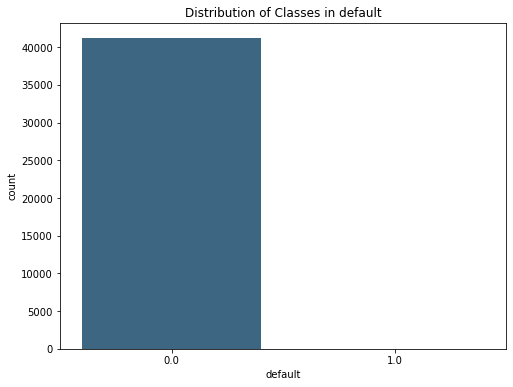

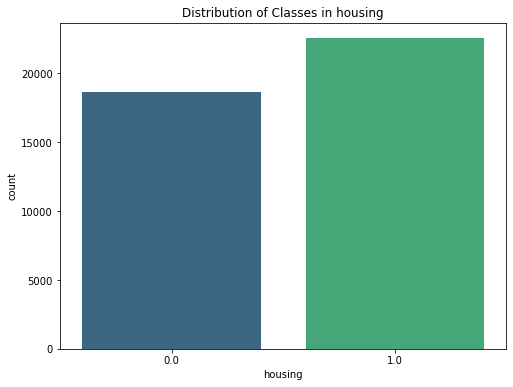

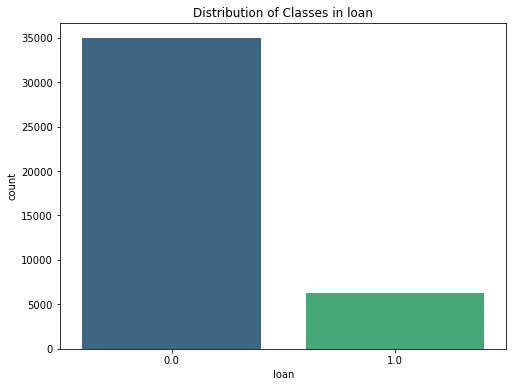

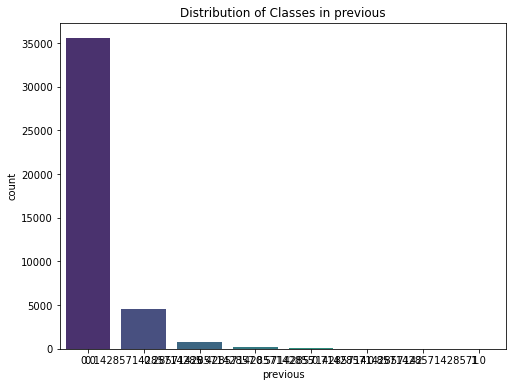

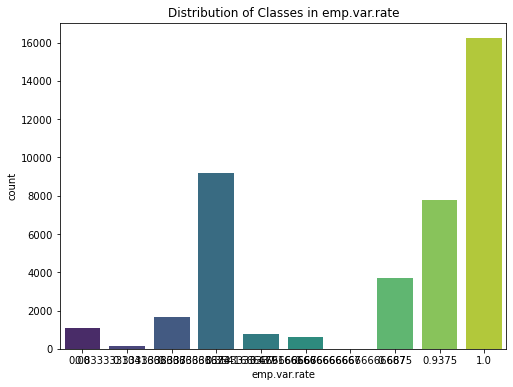

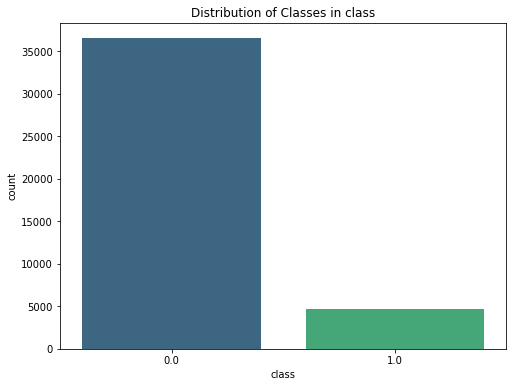

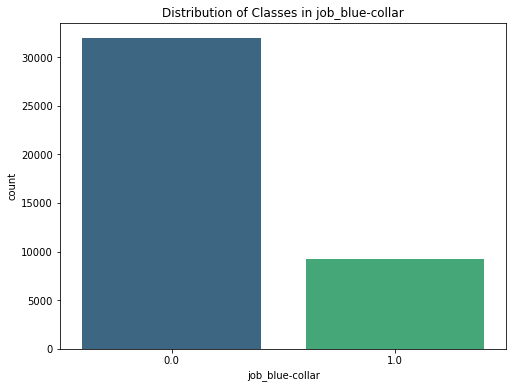

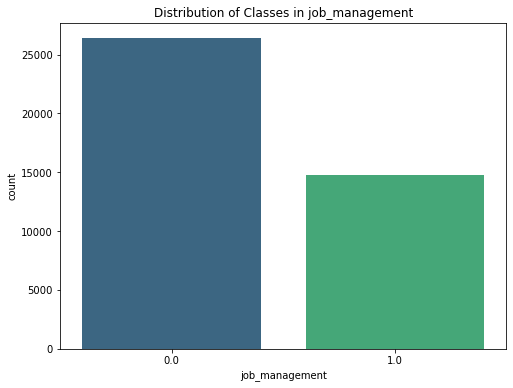

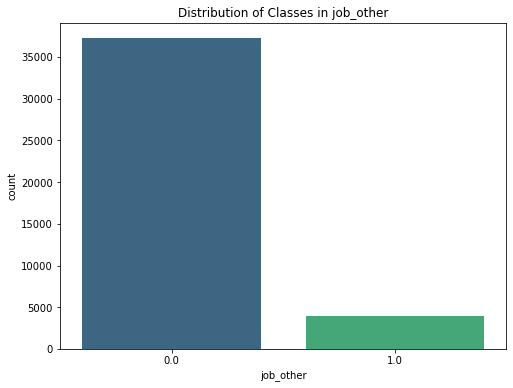

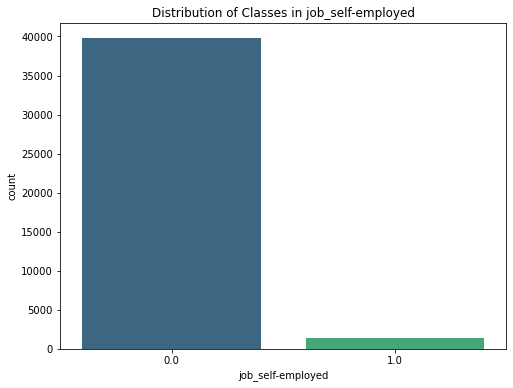

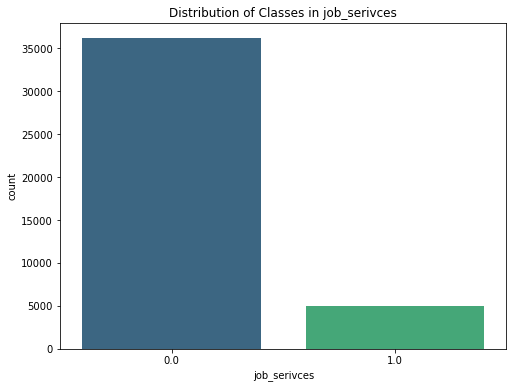

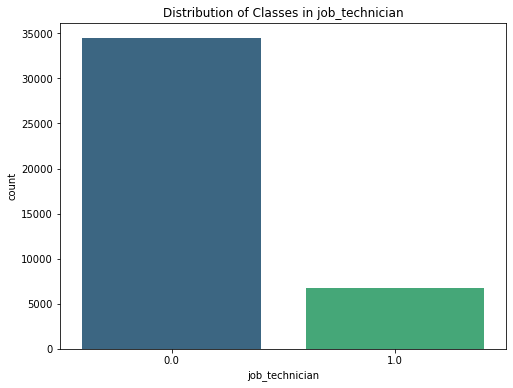

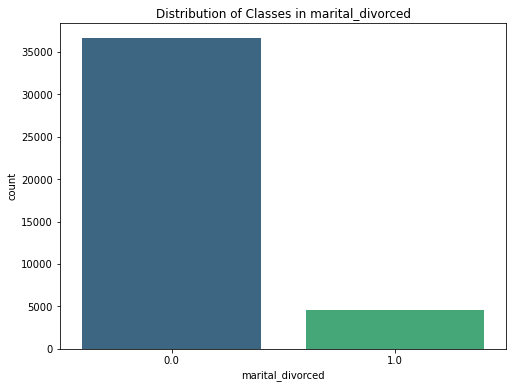

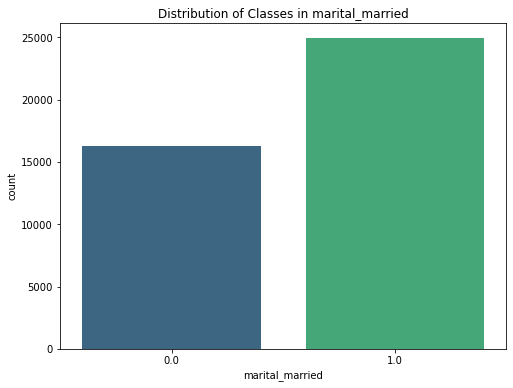

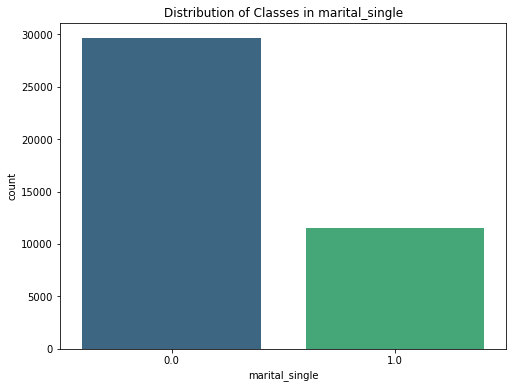

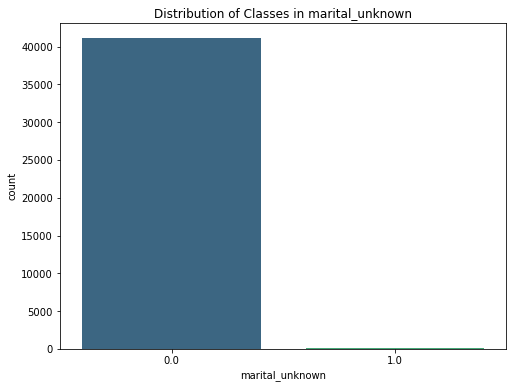

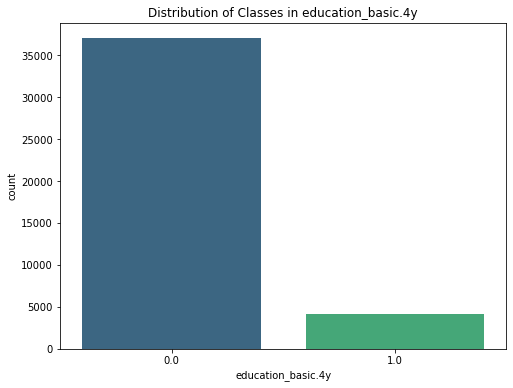

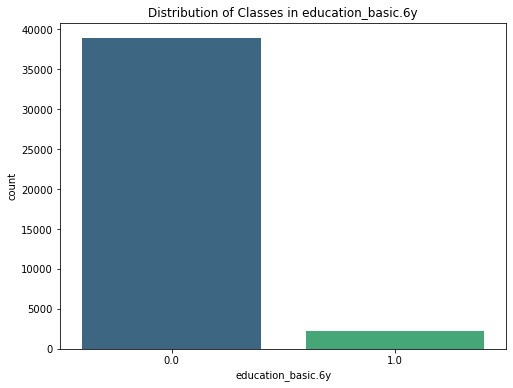

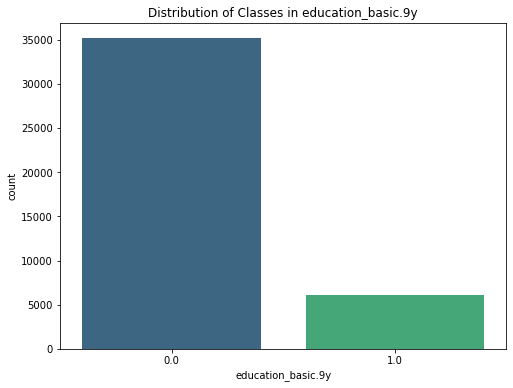

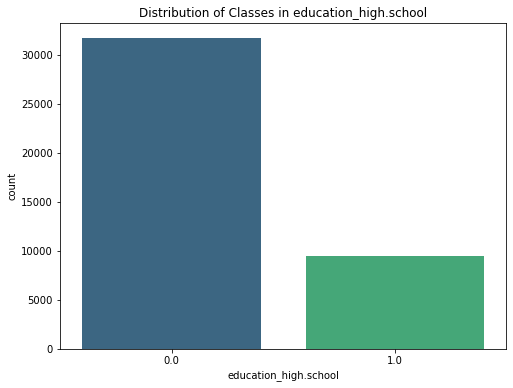

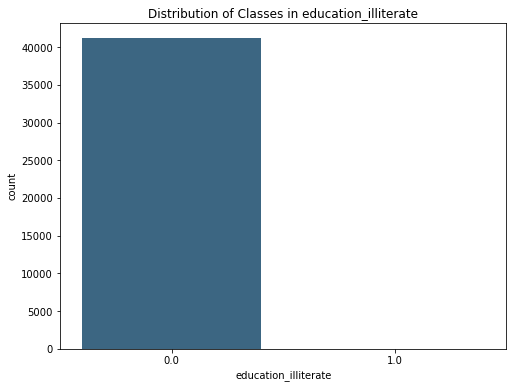

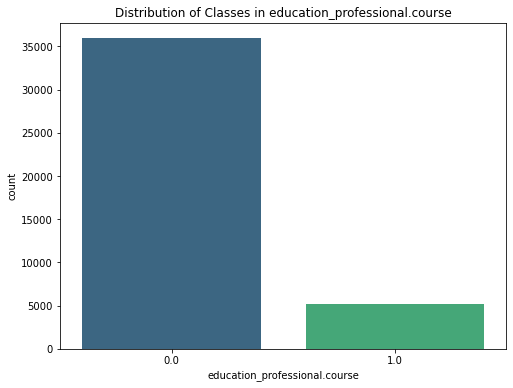

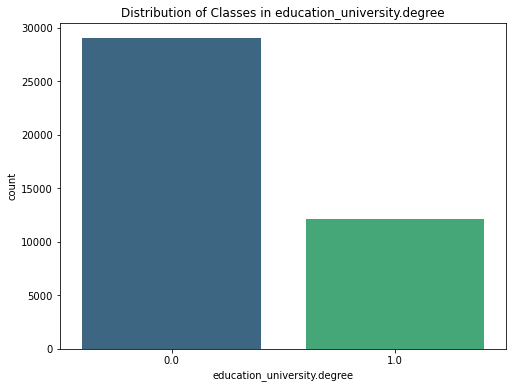

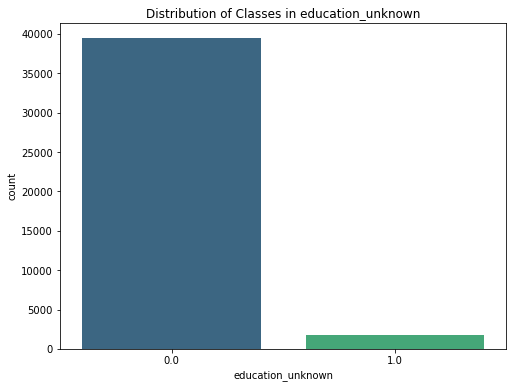

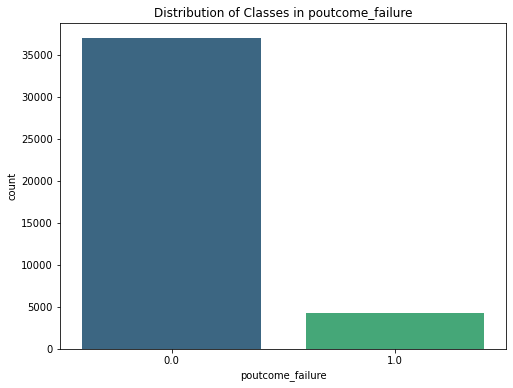

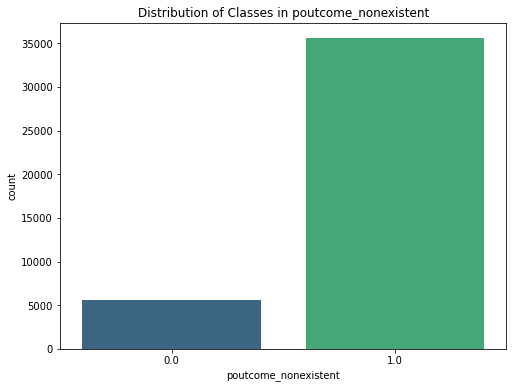

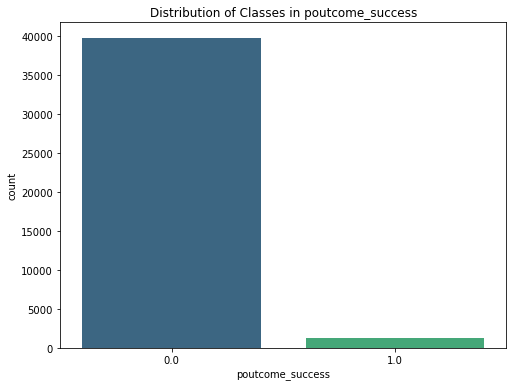

In [93]:
for column in bank_full.columns:
    # Check if the column has a reasonable number of unique values to be considered a class column
    if bank_full[column].nunique() <= 10:  # threshhold
        # Create a bar plot for the distribution of classes in the column
        plt.figure(figsize=(8, 6))
        sns.countplot(x=column, data=bank_full, palette='viridis')
        plt.title(f'Distribution of Classes in {column}')
        plt.show()

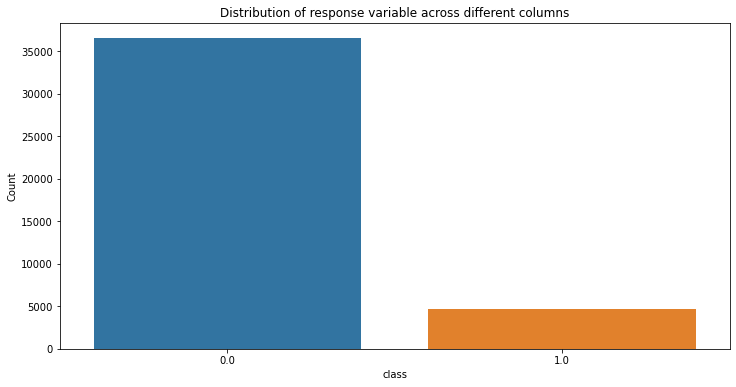

In [101]:

# Create a bar plot for the distribution of the response variable across different columns
plt.figure(figsize=(12, 6))
sns.countplot(x='class', data=bank_full)

plt.title('Distribution of response variable across different columns')
plt.xlabel('class')
plt.savefig('data/bank_marketing/quality_class_distribution.png')
plt.ylabel('Count')
plt.show()